In [2]:
# 将谷歌硬盘安装到CoLab虚拟机上
# from google.colab import drive
# drive.mount('/content/drive')

# TODO:在驱动器中输入保存解压缩文件的文件夹名
# 工作分配文件夹, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/assignments/assignment1'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# 现在我们已经安装了您的驱动器，这确保了Python解释器可以从中加载Python文件。
import sys
sys.path.append('D:/CodeWorkspace/{}'.format(FOLDERNAME))

# 这会将CIFAR-10数据集下载到您的驱动器（如果它还不存在）。
%cd D:/CodeWorkspace/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd D:/CodeWorkspace/$FOLDERNAME

D:\CodeWorkspace\cs231n\assignments\assignment1\cs231n\datasets
�(u�N  L i n u x   �v  W i n d o w s   P[�|�~�l	g�]�[ň�vR�SHr0
 
 
 �S�N�Ǐ���  M i c r o s o f t   S t o r e   eg�[ňR�SHr: 
 
 
 h t t p s : / / a k a . m s / w s l s t o r e 
 
 
 
D:\CodeWorkspace\cs231n\assignments\assignment1


# Softmax 练习

*完成并提交此已完成的工作表（包括其输出和工作表之外的任何支持代码）和作业提交。有关详细信息，请参阅课程网站上的[作业页面](http://vision.stanford.edu/teaching/cs231n/assignments.html)*

此练习类似于 SVM 练习。您将：

- 为 Softmax 分类器实现完全矢量化的**损失函数**
- 实现其**分析梯度**的完全矢量化表达式
- 使用数值梯度**检查您的实现**
- 使用验证集**调整学习率和正则化强度**
- 使用 **SGD 优化**损失函数
- **可视化**最终学习的权重


In [3]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    从磁盘加载CIFAR-10数据集，并进行预处理，为线性分类器做好准备。这些步骤与我们用于SVM的步骤相同，但浓缩为一个函数。
    """
    # 加载原始CIFAR-10数据
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # 清理变量以防止多次加载数据（这可能会导致内存问题）
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # 对数据进行二次采样
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # 预处理：将图像数据重塑为行
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # 规格化数据：减去平均图像
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # 添加偏差维度并转换为列
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# 调用上面的函数来获取我们的数据。
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

本节的代码将全部编写在 `cs231n/classifiers/softmax.py`.


In [39]:
# 首先用嵌套循环实现简单的softmax损失函数。打开文件cs231n/classifiers/softmax.py并实现softmax_loss_naive函数。
from cs231n.classifiers.softmax import softmax_loss_naive
import time

# 生成一个随机的softmax权重矩阵，并使用它来计算损失。
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# 作为一个粗略的健全性检查，我们的损失应该接近-log（0.1）。
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.306566
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.

$\color{blue}{\textit Your Answer:}$ *有十个类，每个类的概率为0.1*



In [40]:
# 完成softmax_loss_naive的实现，并实现使用嵌套循环的计算梯度（naive）版本。
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# 正如我们对SVM所做的那样，使用数值梯度检查作为调试工具。
# 数值梯度应接近分析梯度。
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# 与SVM的情况类似，使用正则化进行另一个梯度检查
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 2.203462 analytic: 2.203462, relative error: 1.748476e-08
numerical: 1.964737 analytic: 1.964737, relative error: 2.263698e-08
numerical: 0.161823 analytic: 0.161823, relative error: 5.968195e-08
numerical: -0.053444 analytic: -0.053444, relative error: 1.963235e-08
numerical: -1.955249 analytic: -1.955248, relative error: 2.297654e-08
numerical: 2.551789 analytic: 2.551789, relative error: 8.531291e-09
numerical: -5.524961 analytic: -5.524961, relative error: 8.778037e-10
numerical: 4.014556 analytic: 4.014556, relative error: 1.358486e-08
numerical: 3.257187 analytic: 3.257187, relative error: 1.441754e-08
numerical: -0.096712 analytic: -0.096712, relative error: 2.779152e-07
numerical: 1.042441 analytic: 1.042441, relative error: 2.340164e-08
numerical: 1.521123 analytic: 1.521122, relative error: 2.284077e-08
numerical: -4.802047 analytic: -4.802047, relative error: 6.467919e-09
numerical: -3.038966 analytic: -3.038966, relative error: 3.397320e-09
numerical: 1.742649 an

In [41]:
# 现在我们有了softmax损失函数及其梯度的简单实现，在softmax_loss_vectorized中实现矢量化版本。
# 这两个版本应该计算相同的结果，但矢量化版本应该更快。
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# 正如我们对SVM所做的那样，我们使用Frobenius范数来比较梯度的两个版本#。
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.306566e+00 computed in 0.056049s
vectorized loss: 2.306566e+00 computed in 0.002006s
Loss difference: 0.000000
Gradient difference: 0.000000


In [42]:
# 使用验证集来调整超参数（正则化强度和学习率）。
# 你应该在不同的学习率和正则化强度范围内进行实验；如果你小心的话，你应该能够在验证集上获得超过0.35的分类准确度。

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = np.random.randint(1,100,10) * 1e-8
regularization_strengths = np.random.randint(1,100,10) * 1e-3

################################################################################
# TODO:                                  #
# 使用验证集设置学习率和正则化强度。 #
# 这应该与您对SVM所做的验证相同；在best_softmax中保存经过最佳训练的softmax分类器。#
################################################################################

# 作为参考提供。您可能想要也可能不想要更改这些超参数
# learning_rates = [1e-7, 5e-7]
# regularization_strengths = [2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

model = Softmax()
for lr in learning_rates:
  for reg in regularization_strengths:
    loss_history = model.train(X_train, y_train, learning_rate = lr, reg = reg, num_iters = 500)
    y_pred_val = model.predict(X_val)
    acc_val = np.sum(y_pred_val == y_val) / len(y_val)
    y_pred_train = model.predict(X_train)
    acc_train = np.sum(y_pred_train == y_train) / len(y_train)
    results[(lr, reg)] = (acc_train, acc_val)
    if acc_val > best_val:
      best_val = acc_val
      best_softmax = model

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# 打印结果
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-08 reg 7.000000e-03 train accuracy: 0.436551 val accuracy: 0.404000
lr 1.000000e-08 reg 1.500000e-02 train accuracy: 0.436837 val accuracy: 0.404000
lr 1.000000e-08 reg 2.000000e-02 train accuracy: 0.436592 val accuracy: 0.404000
lr 1.000000e-08 reg 2.500000e-02 train accuracy: 0.436755 val accuracy: 0.404000
lr 1.000000e-08 reg 5.900000e-02 train accuracy: 0.436408 val accuracy: 0.404000
lr 1.000000e-08 reg 6.200000e-02 train accuracy: 0.436041 val accuracy: 0.403000
lr 1.000000e-08 reg 8.000000e-02 train accuracy: 0.437122 val accuracy: 0.405000
lr 1.000000e-08 reg 8.400000e-02 train accuracy: 0.436939 val accuracy: 0.400000
lr 1.000000e-08 reg 9.500000e-02 train accuracy: 0.437143 val accuracy: 0.405000
lr 1.000000e-08 reg 9.900000e-02 train accuracy: 0.437061 val accuracy: 0.407000
lr 9.000000e-08 reg 7.000000e-03 train accuracy: 0.443306 val accuracy: 0.401000
lr 9.000000e-08 reg 1.500000e-02 train accuracy: 0.441612 val accuracy: 0.405000
lr 9.000000e-08 reg 2.000000

In [43]:
# 在测试集上评估
# 评估测试集上的最佳softmax
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.379000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$



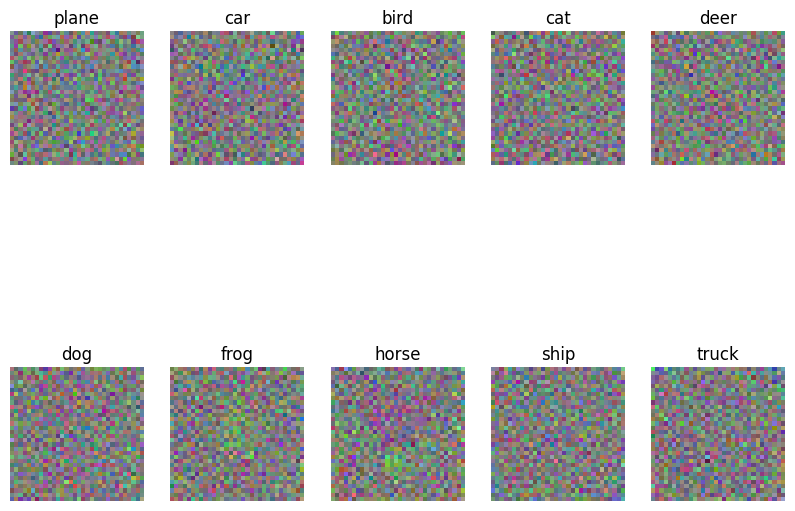

In [44]:
# 将每个类别的学习权重可视化
w = best_softmax.W[:-1,:] # 去掉偏差
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # 将权重重新缩放到0到255之间
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])